### Dataset info

This dataset contains around 210k news headlines from 2012 to 2022 from HuffPost. This is one of the biggest news datasets and can serve as a benchmark for a variety of computational linguistic tasks. HuffPost stopped maintaining an extensive archive of news articles sometime after this dataset was first collected in 2018, so it is not possible to collect such a dataset in the present day. Due to changes in the website, there are about 200k headlines between 2012 and May 2018 and 10k headlines between May 2018 and 2022.

Content
Each record in the dataset consists of the following attributes:

category: category in which the article was published.
headline: the headline of the news article.
authors: list of authors who contributed to the article.
link: link to the original news article.
short_description: Abstract of the news article.
date: publication date of the article.
There are a total of 42 news categories in the dataset. The top-15 categories and corresponding article counts are as follows:

POLITICS: 35602

WELLNESS: 17945

ENTERTAINMENT: 17362

TRAVEL: 9900

STYLE & BEAUTY: 9814

PARENTING: 8791

HEALTHY LIVING: 6694

QUEER VOICES: 6347

FOOD & DRINK: 6340

BUSINESS: 5992

COMEDY: 5400

SPORTS: 5077

BLACK VOICES: 4583

HOME & LIVING: 4320

PARENTS: 3955

In [90]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt



In [91]:
import json
import tensorflow as tf
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import regex as re
import wordcloud
import nltk



In [92]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [93]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## EXPLORATORY DATASET ANALYSIS

This part of the project focuses on understanding the dataset and how the data is distributed in the dataset.

In [94]:
# Read and Preview dataset
data = pd.read_json("News_Category_Dataset_v3.json", lines=True)
data.head(15)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
5,https://www.huffpost.com/entry/belk-worker-fou...,Cleaner Was Dead In Belk Bathroom For 4 Days B...,U.S. NEWS,The 63-year-old woman was seen working at the ...,,2022-09-22
6,https://www.huffpost.com/entry/reporter-gets-a...,Reporter Gets Adorable Surprise From Her Boyfr...,U.S. NEWS,"""Who's that behind you?"" an anchor for New Yor...",Elyse Wanshel,2022-09-22
7,https://www.huffpost.com/entry/puerto-rico-wat...,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...,"DÁNICA COTO, AP",2022-09-22
8,https://www.huffpost.com/entry/mija-documentar...,How A New Documentary Captures The Complexity ...,CULTURE & ARTS,"In ""Mija,"" director Isabel Castro combined mus...",Marina Fang,2022-09-22
9,https://www.huffpost.com/entry/biden-un-russia...,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...,"Aamer Madhani, AP",2022-09-21


In [95]:
# We are unlikely to need all of those features such as data, author and link

data = data[['headline', 'category',  'short_description']]
data.head(15)

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...
5,Cleaner Was Dead In Belk Bathroom For 4 Days B...,U.S. NEWS,The 63-year-old woman was seen working at the ...
6,Reporter Gets Adorable Surprise From Her Boyfr...,U.S. NEWS,"""Who's that behind you?"" an anchor for New Yor..."
7,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...
8,How A New Documentary Captures The Complexity ...,CULTURE & ARTS,"In ""Mija,"" director Isabel Castro combined mus..."
9,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...


In [96]:
# See the unique categories that we will be classifying
data.category.unique()
print(f"There are now: {len(data.category.unique())} unique categories")

There are now: 42 unique categories


In [97]:
# There are several similar categories such as healthy living and wellness.
# These can be merged

data.category = data.category.replace({
    'COLLEGE' : 'EDUCATION',
    'THE WORLDPOST': 'WORLD NEWS',
    'TASTE' : 'FOOD AND DRINK',
    'HEALTHY LIVING' : 'WELLNESS',
    'QUEER VOICES' : 'GROUPS VOICES',
    'BLACK VOICES': 'GROUPS VOICES',
    'GREEN' : 'ENVIRONMENT',
    'LATINO VOICES' : 'GROUPS VOICES',
    'TECH' : 'SCIENCE AND TECH',
    'SCIENCE' : 'SCIENCE AND TECH',
    'WEDDINGS': 'MISCELLANEOUS',
    'FIFTY' : 'MISCELLANEOUS',
    'GOOD NEWS' : 'MISCELLANEOUS',
    'WEIRD NEWS' : 'MISCELLANEOUS',
    'PARENTS' : 'PARENTING',
    "ARTS": "ARTS & CULTURE",
    "BUSINESS": "BUSINESS & FINANCES",
    "MONEY": "BUSINESS & FINANCES",
    "STYLE" : "STYLE & BEAUTY"

})


In [98]:
print(f"There are now: {len(data.category.unique())} unique categories")

There are now: 28 unique categories


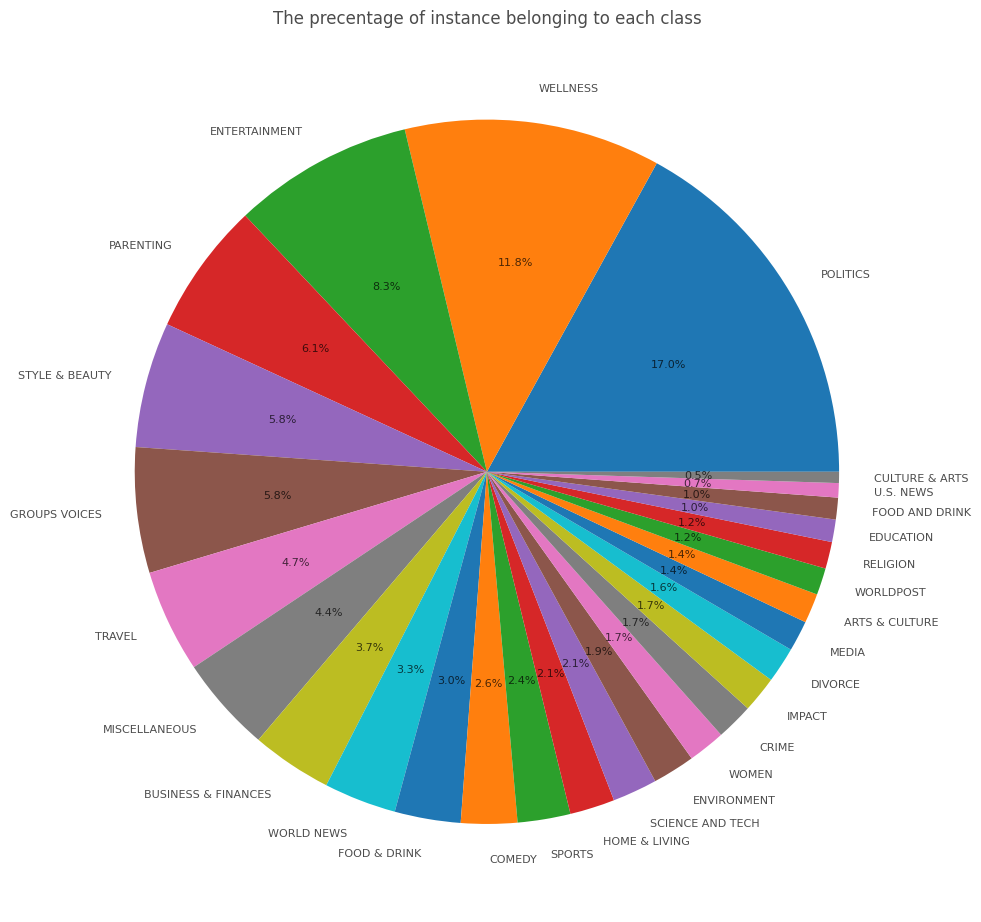

In [99]:
plt.figure(figsize=(10, 10))
plt.pie(x=data.category.value_counts(), labels=data.category.value_counts().index, autopct='%1.1f%%', textprops={'fontsize' : 8,
                                                                                                                'alpha' : .7});
plt.title('The precentage of instance belonging to each class', alpha=.7);
plt.tight_layout();

In [100]:
new_df = data.copy()
new_df['length_of_news'] = new_df['headline'] + new_df['short_description']
new_df.drop(['headline', 'short_description'], inplace=True, axis=1)
new_df['len_news'] = new_df['length_of_news'].map(lambda x:len(x))
new_df.head(15)

,category,length_of_news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233
5,U.S. NEWS,Cleaner Was Dead In Belk Bathroom For 4 Days B...,232
6,U.S. NEWS,Reporter Gets Adorable Surprise From Her Boyfr...,186
7,WORLD NEWS,Puerto Ricans Desperate For Water After Hurric...,181
8,CULTURE & ARTS,How A New Documentary Captures The Complexity ...,224
9,WORLD NEWS,Biden At UN To Call Russian War An Affront To ...,208


In [101]:
max_len_data = new_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news', ascending=False)
max_len_data.head()



# category	len_news
# 17	POLITICS	1486
# 27	WORLDPOST	1424
# 6	EDUCATION	1225
# 24	WELLNESS	1073
# 22	TRAVEL	978

,category,len_news
17,POLITICS,1486
27,WORLDPOST,1424
6,EDUCATION,1225
24,WELLNESS,1073
22,TRAVEL,978


In [102]:
min_len_data = new_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news', ascending=True)
min_len_data.head()

# 23	U.S. NEWS	287
# 26	WORLD NEWS	338
# 10	FOOD AND DRINK	401
# 20	SPORTS	462
# 5	DIVORCE	463

,category,len_news
23,U.S. NEWS,287
26,WORLD NEWS,338
10,FOOD AND DRINK,401
20,SPORTS,462
5,DIVORCE,463


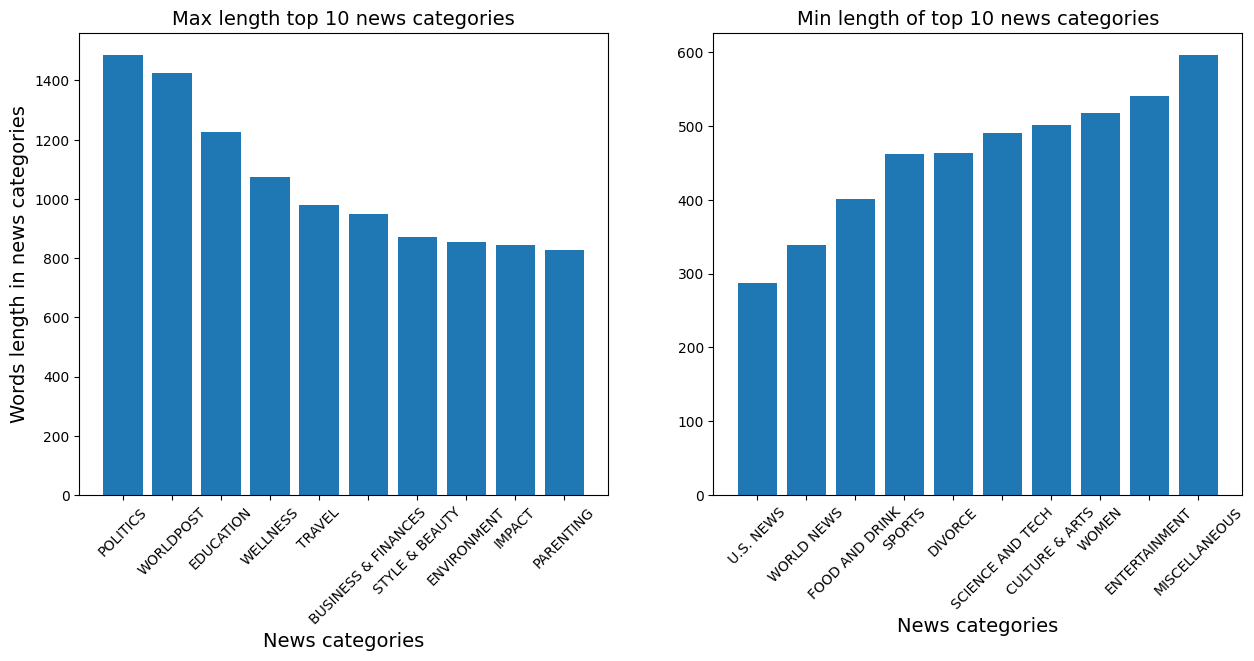

In [103]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(max_len_data['category'][:10],max_len_data['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(min_len_data['category'][:10], min_len_data['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

## Data Preprocessing

In [104]:
nltk.download('stopwords')
nltk.download('wordnet')
# Initialise lemmatiser and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Data clearning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")  # Compile a regular expression to match one or more whitespaces
    user = re.compile(r"(?i)@[a-z0-9_]+")  # Compile a regular expression to match usernames 
    
    text = whitespace.sub(' ', text)  # Replace multiple whitespaces with a single space
    text = user.sub('', text)  # Remove usernames from the text
    
    text = re.sub(r"\[[^()]*\]", "", text)  # Remove all text within square brackets
    text = re.sub("\d+", "", text)  # Remove all digits from the text
    text = re.sub(r'[^\w\s]', '', text)  # Remove all non-word characters except for whitespaces
    
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)  # Remove mentions, hashtags, and URLs
    
    text = text.lower()  # Convert all characters in the text to lowercase

    # Remove stopwords
    text = [word for word in text.split() if word not in stop_words]
    
    # Lemmatisation
    sentence = []
    for word in text:
        sentence.append(lemmatizer.lemmatize(word, pos='v'))

    return ' '.join(sentence)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tom_r\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tom_r\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [105]:
# Checking the preprocessing of the dataclearning function

print("Text sentence before pre-processing:\n",new_df['length_of_news'][1])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(new_df['length_of_news'][1]))

Text sentence before pre-processing:
 American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On VideoHe was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 american airlines flyer charge ban life punch flight attendant videohe subdue passengers crew flee back aircraft confrontation accord us attorneys office los angeles


In [106]:
# Apply the cleaning function to the data
test_df = new_df.copy()
new_df['length_of_news'] = new_df['length_of_news'].apply(datacleaning)

In [107]:
# Check the character lengths
old_length = test_df['length_of_news'].apply(len).sum()  # apply applies len to each element and then sums it
new_length = new_df['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 36169394
New chracters length of text data: 25120819


In [108]:
# length of total words before and after cleaning text data
old_text = test_df['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = new_df['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 5942993
New word length of text data: 3581987


## Tokenisation and vectorisation

### LabelEncoder:

- **Generally used for**: Encoding target labels (i.e., the \( y \) in a machine learning problem).
- **Functionality**: Encodes categorical string labels into integers.
- **Unique Labels**: All unique labels get a unique integer.
- **Frequency and Order**: Does not consider the frequency or order of the words.

### Tokenizer:

- **Generally used for**: Encoding feature data (i.e., the \( X \) in a machine learning problem).
- **Functionality**: Used for text data that is more complex than simple categories, like sentences or paragraphs.
- **Encoding Methods**: Can convert each unique word in the text to a unique integer or a one-hot vector.
- **Additional Features**: Can also take into account the frequency of words to build a limited vocabulary, among other functionalities.
- **Padding**: It can also pad sequences to ensure that they all have the same length, which is crucial for certain types of models like RNNs and LSTMs.


In [109]:
X = new_df['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(new_df['category'])
print("Shape of the input data: ", X.shape)
print("Shape of the targer variable", y.shape)

Shape of the input data:  (209527,)
Shape of the targer variable (209527,)


In [110]:
# Print the unique classes that have been encoded
print("Classes:", encoder.classes_)

# Create a mapping of class labels to integers
label_mapping = {label: idx for idx, label in enumerate(encoder.classes_)}
print("Label to integer mapping:", label_mapping)


Classes: ['ARTS & CULTURE' 'BUSINESS & FINANCES' 'COMEDY' 'CRIME' 'CULTURE & ARTS'
 'DIVORCE' 'EDUCATION' 'ENTERTAINMENT' 'ENVIRONMENT' 'FOOD & DRINK'
 'FOOD AND DRINK' 'GROUPS VOICES' 'HOME & LIVING' 'IMPACT' 'MEDIA'
 'MISCELLANEOUS' 'PARENTING' 'POLITICS' 'RELIGION' 'SCIENCE AND TECH'
 'SPORTS' 'STYLE & BEAUTY' 'TRAVEL' 'U.S. NEWS' 'WELLNESS' 'WOMEN'
 'WORLD NEWS' 'WORLDPOST']
Label to integer mapping: {'ARTS & CULTURE': 0, 'BUSINESS & FINANCES': 1, 'COMEDY': 2, 'CRIME': 3, 'CULTURE & ARTS': 4, 'DIVORCE': 5, 'EDUCATION': 6, 'ENTERTAINMENT': 7, 'ENVIRONMENT': 8, 'FOOD & DRINK': 9, 'FOOD AND DRINK': 10, 'GROUPS VOICES': 11, 'HOME & LIVING': 12, 'IMPACT': 13, 'MEDIA': 14, 'MISCELLANEOUS': 15, 'PARENTING': 16, 'POLITICS': 17, 'RELIGION': 18, 'SCIENCE AND TECH': 19, 'SPORTS': 20, 'STYLE & BEAUTY': 21, 'TRAVEL': 22, 'U.S. NEWS': 23, 'WELLNESS': 24, 'WOMEN': 25, 'WORLD NEWS': 26, 'WORLDPOST': 27}


In [111]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [112]:
# Tokenizing the dataset
tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Build the word index

# Convert texts to sequences
train_seq = tokenizer.texts_to_sequences(X_train)

# Calculate the lengths of sequences
sequence_lengths = [len(seq) for seq in train_seq]


# To get statistical measures
print("Mean sequence length:", np.mean(sequence_lengths))
print("Median sequence length:", np.median(sequence_lengths))
print("Standard deviation of sequence lengths:", np.std(sequence_lengths))

# Padding training input data
train_padseq = pad_sequences(train_seq, maxlen=20)

# Padding test input data
test_seq = tokenizer.texts_to_sequences(X_test)  
test_padseq = pad_sequences(test_seq, maxlen=20) 


word_index = tokenizer.word_index
max_words = 150000
total_words = len(word_index)

maxlen = 20  # max length of sequence

y_train = to_categorical(y_train, num_classes=28)
y_test = to_categorical(y_test, num_classes=28)
print("Length of word index: ", total_words)


Mean sequence length: 17.084995316815913
Median sequence length: 17.0
Standard deviation of sequence lengths: 7.2209846828125706
Length of word index:  190686


In [113]:
print(maxlen)

20


## Word embeddings

A word embedding is a learned representation for text where words that have the same meaning and save similar representation

Keras has an embedding layer what can provide word embedding given a corpus of text

In [114]:
def train_and_evaluate_model(model, train_data, train_labels, test_data, test_labels,
                             batch_size=128, epochs=10, validation_split=0.2):
    # Compile the model
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Fit the model
    history = model.fit(train_data, train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=validation_split)
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")
    
    return model, history

## Baseline

In [115]:
# A simple baseline modle with the keras embedding layer and RNN

model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(28, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 70)            13348020  
                                                                 
 bidirectional_10 (Bidirecti  (None, 20, 128)          17280     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 28)               

In [116]:
model, history = train_and_evaluate_model(model, train_padseq, y_train, test_padseq, y_test)
model.save("news_clf_exp01.h5")

Epoch 1/10
1048/1048 [==============================] - 181s 169ms/step - loss: 2.6838 - accuracy: 0.2666 - val_loss: 2.1752 - val_accuracy: 0.4104
Epoch 2/10
1048/1048 [==============================] - 178s 170ms/step - loss: 2.0622 - accuracy: 0.4414 - val_loss: 1.9247 - val_accuracy: 0.4778
Epoch 3/10
1048/1048 [==============================] - 179s 171ms/step - loss: 1.8248 - accuracy: 0.5079 - val_loss: 1.8141 - val_accuracy: 0.5013
Epoch 4/10
1048/1048 [==============================] - 180s 171ms/step - loss: 1.6977 - accuracy: 0.5463 - val_loss: 1.7404 - val_accuracy: 0.5352
Epoch 5/10
1048/1048 [==============================] - 177s 169ms/step - loss: 1.5991 - accuracy: 0.5746 - val_loss: 1.6988 - val_accuracy: 0.5511
Epoch 6/10
1048/1048 [==============================] - 178s 170ms/step - loss: 1.5268 - accuracy: 0.5934 - val_loss: 1.7313 - val_accuracy: 0.5496
Epoch 7/10
1048/1048 [==============================] - 178s 170ms/step - loss: 1.4666 - accuracy: 0.6110 - val_

## LSTMs

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 70, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model2.add(SimpleRNN(32, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(28, activation='softmax'))
model2.summary()

# Drop out parameters removed to overcome slow training time
# WARNING:tensorflow:Layer lstm_8 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            13352640  
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          69120     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 28)               

In [ ]:
model2, history2 = train_and_evaluate_model(model2, train_padseq, y_train, test_padseq, y_test)
model2.save("news_clf_exp02.h5")

Epoch 1/15
1048/1048 [==============================] - 53s 44ms/step - loss: 2.1685 - accuracy: 0.4146 - val_loss: 1.7909 - val_accuracy: 0.5130
Epoch 2/15
1048/1048 [==============================] - 43s 41ms/step - loss: 1.6292 - accuracy: 0.5624 - val_loss: 1.6101 - val_accuracy: 0.5633
Epoch 3/15
1048/1048 [==============================] - 43s 41ms/step - loss: 1.3947 - accuracy: 0.6239 - val_loss: 1.5134 - val_accuracy: 0.5905
Epoch 4/15
 642/1048 [=================>............] - ETA: 15s - loss: 1.2266 - accuracy: 0.6683

KeyboardInterrupt: 

## Convolutional

In [ ]:
model3 = Sequential()
model3.add(Embedding(total_words, 70, input_length=maxlen))
model3.add(Conv1D(64, 5, activation='relu'))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(28, activation='softmax'))

In [ ]:
model3, history3 = train_and_evaluate_model(model3, train_padseq, y_train, test_padseq, y_test)
model3.save("news_clf_exp03.h5")

## Hybrid

In [ ]:
model4 = Sequential()
model4.add(Embedding(total_words, 70, input_length=maxlen))
model4.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model4.add(Conv1D(64, 5, activation='tanh'))
model4.add(Dropout(0.2))
model4.add(SimpleRNN(32, activation='tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(28, activation='softmax'))
model4.summary()


In [ ]:
model4, history4 = train_and_evaluate_model(model4, train_padseq, y_train, test_padseq, y_test)
model4.save("news_clf_exp04.h5")

## Hybrid 2

In [ ]:
model5 = Sequential()
model5.add(Embedding(total_words, 100, input_length=maxlen))
model5.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Conv1D(72, 3, activation='relu'))
model5.add(MaxPooling1D(2))
model5.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model5.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model5.add(Dropout(0.2))
model5.add(Dense(41, activation='softmax'))
model5.summary()

In [ ]:
model5, history5 = train_and_evaluate_model(model5, train_padseq, y_train, test_padseq, y_test)
model5.save("news_clf_exp05.h5")

### Plotting the results of the different model iterations

In [ ]:


def plot_multiple_histories(histories, start_at=1):
    plt.figure(figsize=(12, 6))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories, start=start_at):
        plt.plot(history.history['accuracy'], label=f'Training accuracy {i}')
        plt.plot(history.history['val_accuracy'], label=f'Validation accuracy {i}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories, start=start_at):
        plt.plot(history.history['loss'], label=f'Training loss {i}')
        plt.plot(history.history['val_loss'], label=f'Validation loss {i}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
histories = [history, history2, history3, history4, history5]
plot_multiple_histories(histories)
